# Pokemons Types - Multiclass classification - Part 2

The goal of this project is to build a computer vision model that predicts a Pokemon’s type from its image.
Each Pokemon has one or two types (e.g., Water, or Ghost + Grass). Therefore, the prediction task must support two labels per image (at most)

Target outcome: Predict Type1 (primary type) and Type2 (secondary type, optional).

Improve model generalization and reach significantly better validation/test performance compared to baseline models.
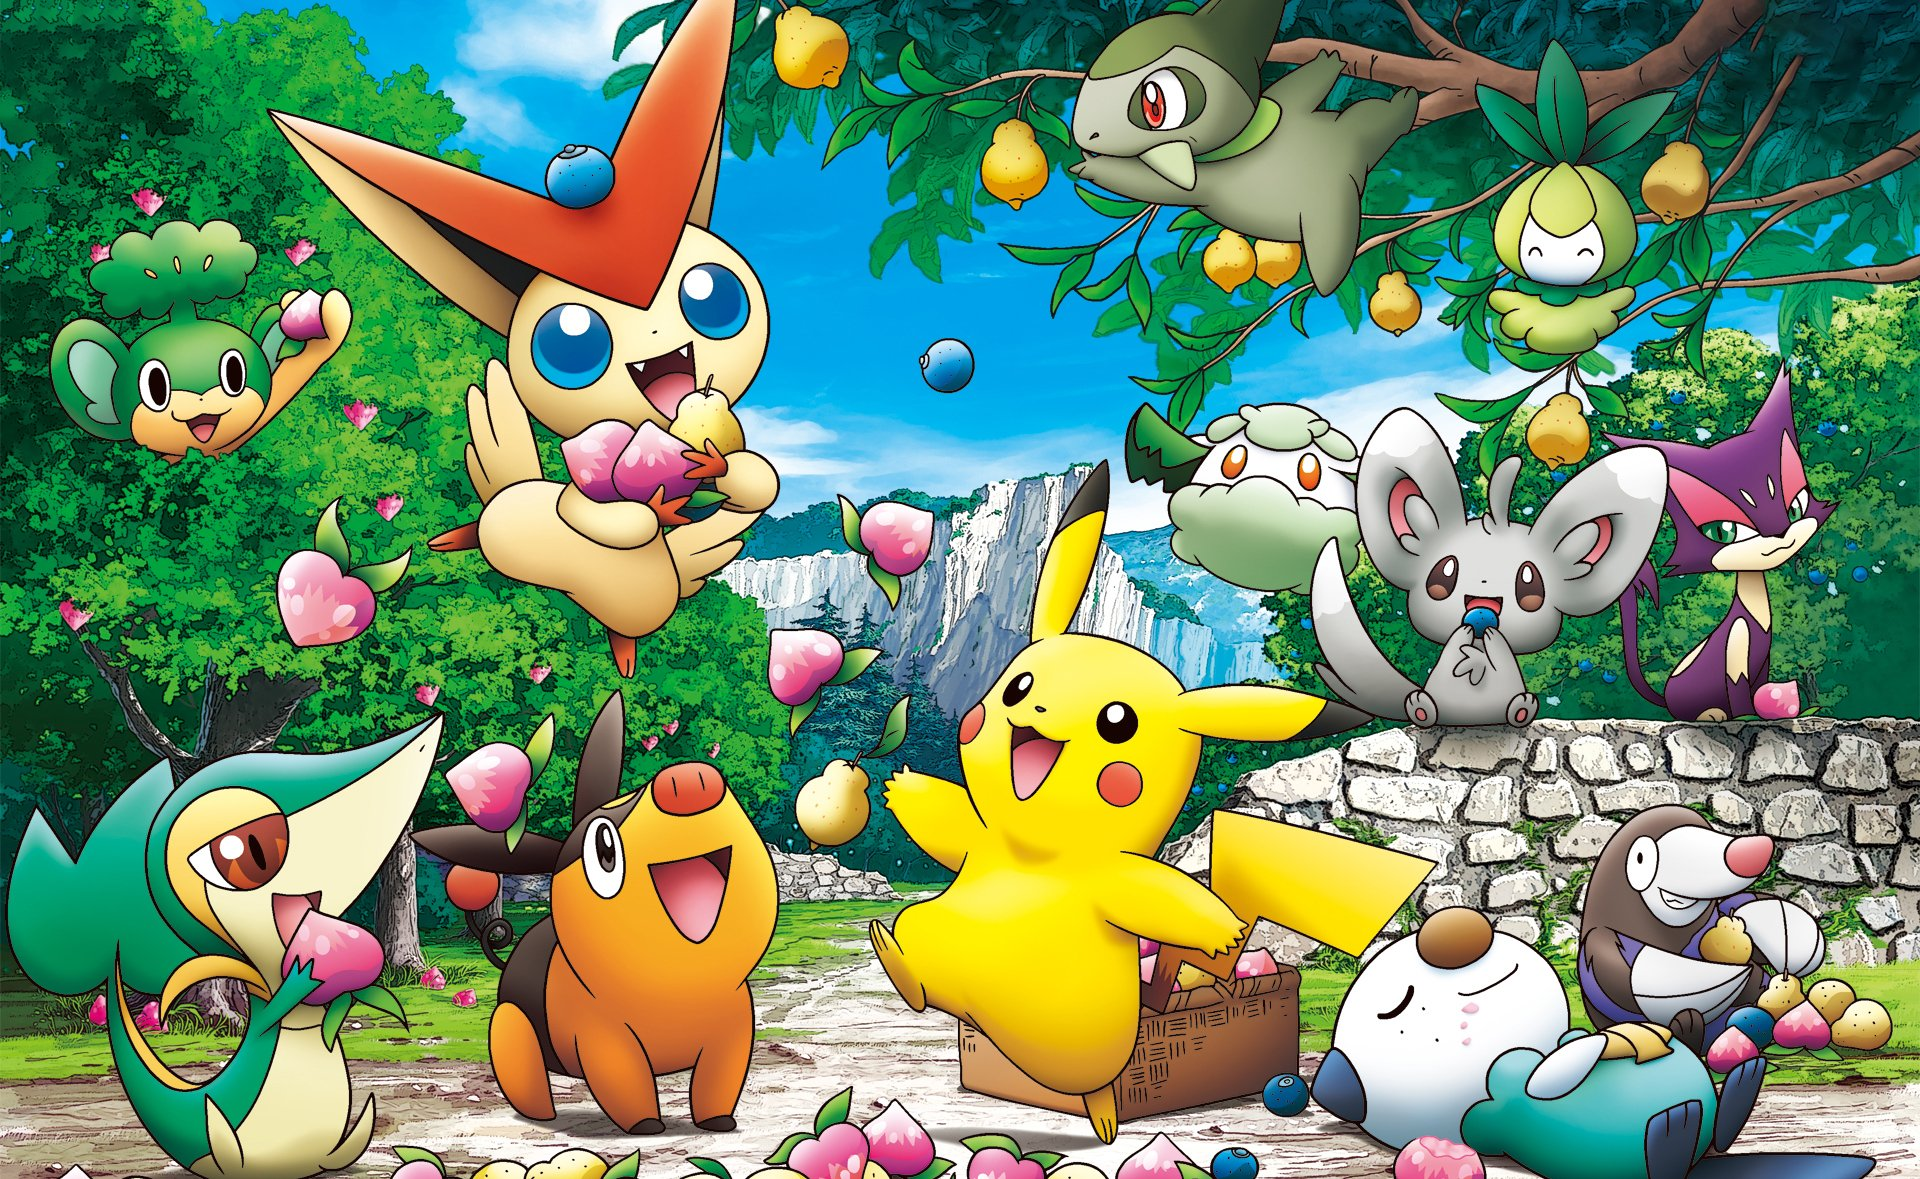

In [ ]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

## Dataset

- **Data source -** The Dataset was downloaded using kagglehub: vishalsubbiah/pokemon-images-and-types

-  **About Dataset -** Images of all Pokemon from generation 1 to generation 7, along with their types (primary and secondary) as a csv.

In [ ]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pokemon-images-and-types' dataset.
Path to dataset files: /kaggle/input/pokemon-images-and-types


In [ ]:
pokemons_csv_data = pd.read_csv("/kaggle/input/pokemon-images-and-types/pokemon.csv")
pokemons_csv_data.head()

Name  Type1   Type2   Evolution
0   bulbasaur  Grass  Poison     ivysaur
1     ivysaur  Grass  Poison    venusaur
2    venusaur  Grass  Poison         NaN
3  charmander   Fire     NaN  charmeleon
4  charmeleon   Fire     NaN   charizard

In [ ]:
pokemons_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       809 non-null    object
 1   Type1      809 non-null    object
 2   Type2      405 non-null    object
 3   Evolution  32 non-null     object
dtypes: object(4)
memory usage: 25.4+ KB


In [ ]:
images_data = "/kaggle/input/pokemon-images-and-types/images"

Show some examples of images in the dataset

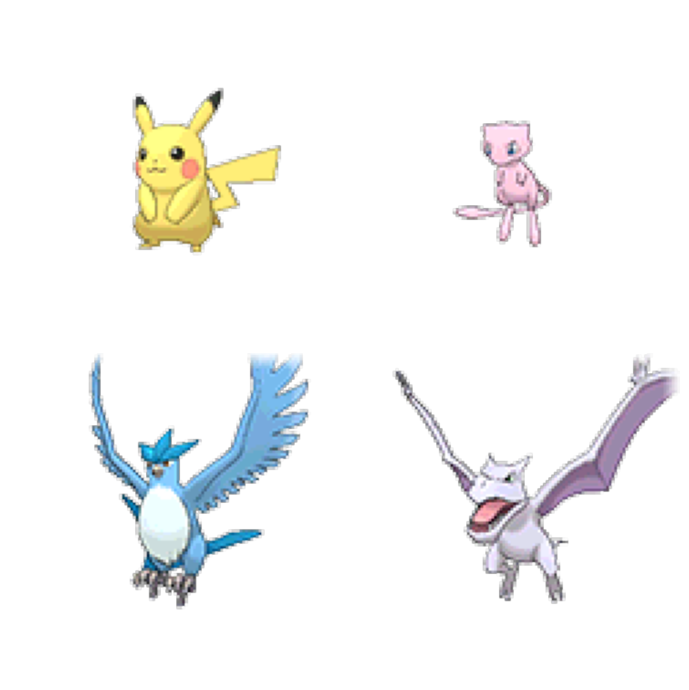

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.reshape(-1)


axes[0].imshow(Image.open('/kaggle/input/pokemon-images-and-types/images/pikachu.png'))
axes[1].imshow(Image.open('/kaggle/input/pokemon-images-and-types/images/mew.png'))
axes[2].imshow(Image.open('/kaggle/input/pokemon-images-and-types/images/articuno.png'))
axes[3].imshow(Image.open('/kaggle/input/pokemon-images-and-types/images/aerodactyl.png'))

for ax in axes:
    ax.axis(False)

plt.tight_layout()

Printing some information about the images: image format ormat, image mode and image size

In [ ]:
import os
from PIL import Image
def print_image_info(path):
    with Image.open(path) as img:
        print("Path:", path)
        print("Image format:", img.format)
        print("Mode:", img.mode)
        print("Image size (WxH):", img.size)

        if img.info:
            print("Info keys:", list(img.info.keys()))

    if os.path.exists(path):
        size_bytes = os.path.getsize(path)
        print("File size:", f"{size_bytes:,} bytes ({size_bytes/1024:.1f} KB)")

    print("-" * 60)

In [ ]:
print_image_info('/kaggle/input/pokemon-images-and-types/images/pikachu.png')
print_image_info('/kaggle/input/pokemon-images-and-types/images/mew.png')

Path: /kaggle/input/pokemon-images-and-types/images/pikachu.png
Image format: PNG
Mode: RGBA
Image size (WxH): (120, 120)
File size: 3,166 bytes (3.1 KB)
------------------------------------------------------------
Path: /kaggle/input/pokemon-images-and-types/images/mew.png
Image format: PNG
Mode: RGBA
Image size (WxH): (120, 120)
File size: 2,030 bytes (2.0 KB)
------------------------------------------------------------


## Data Preprocessing

Matching the csv file type1 and type2 to their pokemon image

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [ ]:
pokemons_csv_data.head()

Name  Type1   Type2   Evolution
0   bulbasaur  Grass  Poison     ivysaur
1     ivysaur  Grass  Poison    venusaur
2    venusaur  Grass  Poison         NaN
3  charmander   Fire     NaN  charmeleon
4  charmeleon   Fire     NaN   charizard

In [ ]:
LABELS = pokemons_csv_data['Type1'].unique()
print(LABELS)

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']


Merge Type1 and Type2, note: we want to do multiclass classification

In [ ]:
def merge_type_strings(row):
    t1 = row['Type1']
    t2 = row['Type2']

    if t2 is np.nan:
        return t1

    return t1 + ' ' + t2



pokemons_csv_data['Type'] = pokemons_csv_data.apply(lambda row: merge_type_strings(row), axis=1)
pokemons_csv_data.head()

Name  Type1   Type2   Evolution          Type
0   bulbasaur  Grass  Poison     ivysaur  Grass Poison
1     ivysaur  Grass  Poison    venusaur  Grass Poison
2    venusaur  Grass  Poison         NaN  Grass Poison
3  charmander   Fire     NaN  charmeleon          Fire
4  charmeleon   Fire     NaN   charizard          Fire

Analyze the pokemons labels frequencies

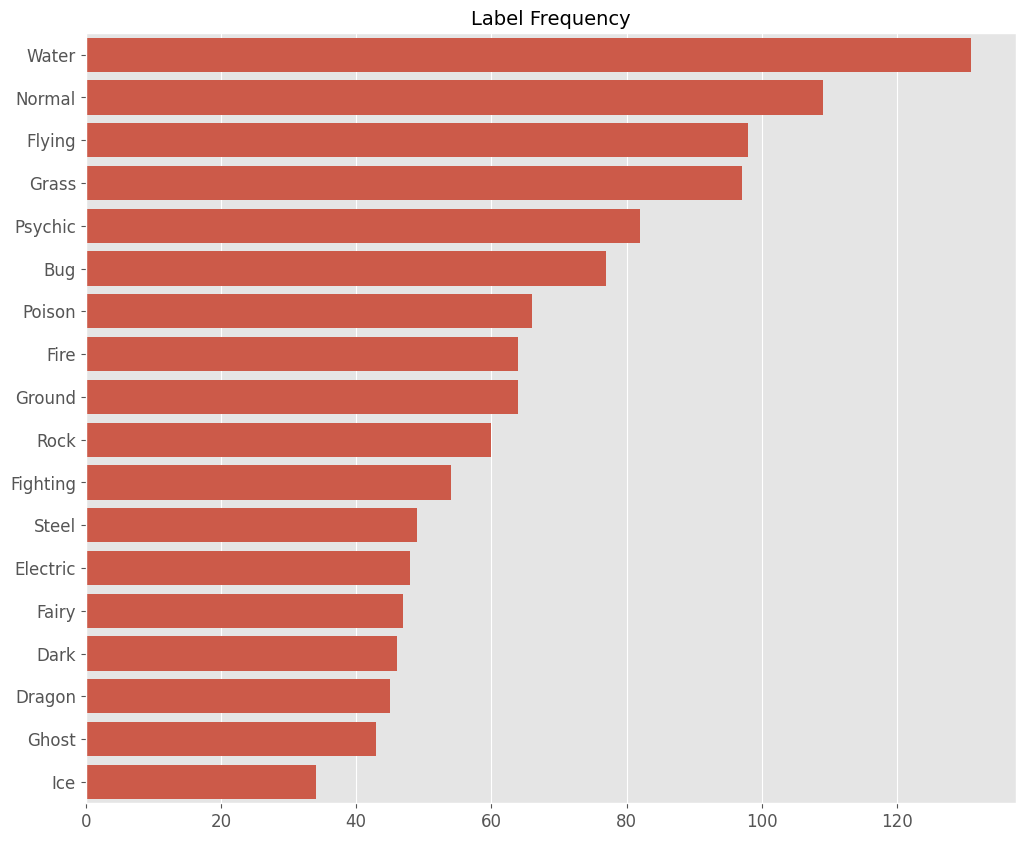

In [ ]:
# get label frequencies in descending order
label_freq = pokemons_csv_data['Type'].apply(lambda s: str(s).split(' ')).explode().value_counts().sort_values(ascending=False)

mpl.style.use("ggplot")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label Frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Data Preparation

Our goal is to produce a tf.data.Dataset that serves (image, label) batches during training.

* Image: a normalized, rescaled RBG tensor. Shape of image is (DIM_H, DIM_W, 3)
* Label: a multi-hot encoded vector of types. A pokemon can have 1 or 2 types. There is a 18 diffrent types of pokemons so the length of the vector is 18.
* Example: Water and Flying pokemon vector: [0,0,1,0, ..., 1, ..., 0]

**Make the type column so that it will be a List of Types**

In [ ]:
# make the Type column a list
pokemons_csv_data['Type'] = pokemons_csv_data['Type'].apply(lambda s: [l for l in str(s).split(' ')])
pokemons_csv_data.head()

Name  Type1   Type2   Evolution             Type
0   bulbasaur  Grass  Poison     ivysaur  [Grass, Poison]
1     ivysaur  Grass  Poison    venusaur  [Grass, Poison]
2    venusaur  Grass  Poison         NaN  [Grass, Poison]
3  charmander   Fire     NaN  charmeleon           [Fire]
4  charmeleon   Fire     NaN   charizard           [Fire]

**Train/Validation/Test split**

Split the data to train set Validation set and Test set

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(pokemons_csv_data['Name'], pokemons_csv_data['Type'], test_size=0.05)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1)

print("Training set size: \t", len(X_train))
print("Validation set size: \t", len(X_val))
print("Test set size: \t\t", len(X_test))

Training set size: 	 691
Validation set size: 	 77
Test set size: 		 41


**Add the type label to each pokemon image**

In [ ]:
import os
images_dir = "/kaggle/input/pokemon-images-and-types/images"

X_train = [os.path.join(images_dir, f"{name}.png") for name in X_train]
X_val   = [os.path.join(images_dir, f"{name}.png") for name in X_val]
X_test  = [os.path.join(images_dir, f"{name}.png") for name in X_test]

X_train[:3]

['/kaggle/input/pokemon-images-and-types/images/stoutland.png',
 '/kaggle/input/pokemon-images-and-types/images/vaporeon.png',
 '/kaggle/input/pokemon-images-and-types/images/qwilfish.png']

Convert Y variables from Series to List. Easier to process and index when building the pipeline.

In [ ]:
y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

y_train[:3]

[['Normal'], ['Water'], ['Water', 'Poison']]

**View the training data**

For each pokemon image we show his type (1 type or 2 types)

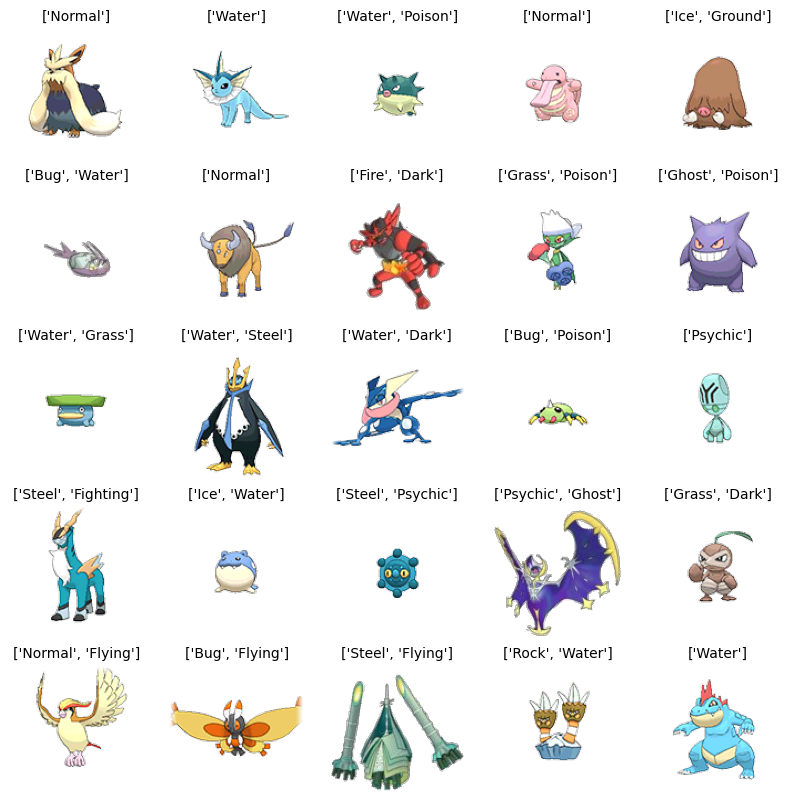

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.reshape(-1)):

    img_path = X_train[i]
    label = y_train[i]

    ax.set_title(label, size=10)
    ax.imshow(Image.open(str(img_path)))
    ax.axis(False)


### Label Encoding

Using sklearn MultiLabelBinarizer to multi-hot encode the labels (we have 18 diffrent)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

type_encoding = {}

mlb = MultiLabelBinarizer()
mlb.fit(y_train)

print("Labels: ")
# loop over all labels and show them
N_LABELS = len(mlb.classes_)
for i, label in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))
    type_encoding[i] = label


Labels: 
0. Bug
1. Dark
2. Dragon
3. Electric
4. Fairy
5. Fighting
6. Fire
7. Flying
8. Ghost
9. Grass
10. Ground
11. Ice
12. Normal
13. Poison
14. Psychic
15. Rock
16. Steel
17. Water


Transform the targets of the training and test sets


In [ ]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)
y_test_bin = mlb.transform(y_test)


# print example of pokemons img path and their binary represent
for i in range(5):
    print(X_train[i], y_train_bin[i])

/kaggle/input/pokemon-images-and-types/images/stoutland.png [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
/kaggle/input/pokemon-images-and-types/images/vaporeon.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
/kaggle/input/pokemon-images-and-types/images/qwilfish.png [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
/kaggle/input/pokemon-images-and-types/images/lickitung.png [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
/kaggle/input/pokemon-images-and-types/images/piloswine.png [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]


**Verify data shapes**

In [ ]:
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((691, 18), (77, 18), (41, 18))

In [ ]:
print(f"Training set images number: {len(X_train)}")
print(f"Validation set images number: {len(X_val)}")
print(f"Test set images number: {len(X_test)}")

Training set images number: 691
Validation set images number: 77
Test set images number: 41


Print the first image of x_train

['Normal']


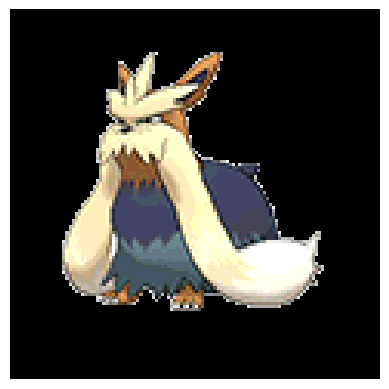

In [ ]:
img = Image.open(X_train[0]).convert("RGB")
label = y_train[0]
print(label)
plt.imshow(img); plt.axis("off"); plt.show()

We are ready to build the tf.data.Dataset. In these functions, we must use tf API and operate with tensor objects.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from PIL import Image

print(tf.__version__)

2.19.0


In [ ]:
# variables
IMG_HEIGHT = 120
IMG_WIDTH = 120
CHANNELS = 3

In [ ]:
import ast

types = sorted({
    t
    for cell in pokemons_csv_data["Type"].astype(str)
    for t in ast.literal_eval(cell)   # "['Bug','Electric']" -> ['Bug','Electric']
})
print(types)
print("num types:", len(types))

['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']
num types: 18


In [ ]:
def set_type_encoding(encoding: dict):
    global type_encoding
    type_encoding = encoding
    type_encoding = {int(k):v for k, v in type_encoding.items()}
    type_encoding

type_encoding = {i: t for i, t in enumerate(types)}
set_type_encoding(type_encoding)
print("output type encoding")
print(type_encoding)

output type encoding
{0: 'Bug', 1: 'Dark', 2: 'Dragon', 3: 'Electric', 4: 'Fairy', 5: 'Fighting', 6: 'Fire', 7: 'Flying', 8: 'Ghost', 9: 'Grass', 10: 'Ground', 11: 'Ice', 12: 'Normal', 13: 'Poison', 14: 'Psychic', 15: 'Rock', 16: 'Steel', 17: 'Water'}


In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE # adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # shuffle the training data by a chunck of this many observations

In [ ]:
def augment(img):
    # img assumed float32 in [0,1]
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]

    # translate/zoom via pad + random crop
    pad = 10
    x = tf.image.resize_with_crop_or_pad(img, h + pad, w + pad)
    x = tf.image.random_crop(x, size=[h, w, 3])

    # small brightness/contrast
    x = tf.image.random_brightness(x, max_delta=0.06)
    x = tf.image.random_contrast(x, lower=0.92, upper=1.08)

    # small saturation
    x = tf.image.random_saturation(x, lower=0.95, upper=1.05)

    # optional horizontal flip
    x = tf.cond(tf.random.uniform([]) < 0.5,
                lambda: tf.image.flip_left_right(x),
                lambda: x)

    # tiny noise
    x = x + tf.random.normal(tf.shape(x), stddev=0.012)

    x = tf.clip_by_value(x, 0.0, 1.0)
    return x

In [ ]:
def parse_function_augment(filename, label):
    """ Returns a tuple of (normalized image array, label)
    Apply transformation as well (this function is for training images).

    filename:  string representing path to image
    label: multi-hot encoded array of size N_LABELS
    """

    img_string = tf.io.read_file(filename)
    img_decoded = tf.image.decode_png(img_string, channels=CHANNELS)
    img_resized = tf.image.resize(img_decoded, [IMG_HEIGHT, IMG_WIDTH])
    img_normed = img_resized / 255.0

    img_aug = augment(img_normed)

    return img_aug, label


In [ ]:

def parse_function(filename, label):
    """ Returns a tuple of (normalized image array, label)
    filename:  string representing path to image
    label: multi-hot encoded array of size N_LABELS
    """

    # read image from file
    img_string = tf.io.read_file(filename)

    # decode it into a vector
    img_decoded = tf.image.decode_png(img_string, channels=CHANNELS)

    # resize it to a fixed shape
    img_resized = tf.image.resize(img_decoded, [IMG_HEIGHT, IMG_WIDTH])

    # normalize it to 0-1 scale
    img_normed = img_resized / 255.0

    return img_normed, label

In [ ]:
def create_dataset(filenames, labels, SHUFFLE_BUFFER_SIZE,
                    AUTOTUNE, BATCH_SIZE, augment=True):
    """ Load and parse a tf.data.Dataset.
    filenames: list of image paths
    labels: numpy array of shape (BATCH_SIZE, N_LABELS)
    """

    # create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if augment is True:
        dataset = dataset.map(parse_function_augment, num_parallel_calls=AUTOTUNE)
    else:

        dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)


    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)


    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [ ]:
train_base = create_dataset(X_train, y_train_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=False)
train_aug  = create_dataset(X_train, y_train_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=True) # doing augmentation
val_ds = create_dataset(X_val, y_val_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=False)
test_ds = create_dataset(X_test, y_test_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=False)

Show images from train aug

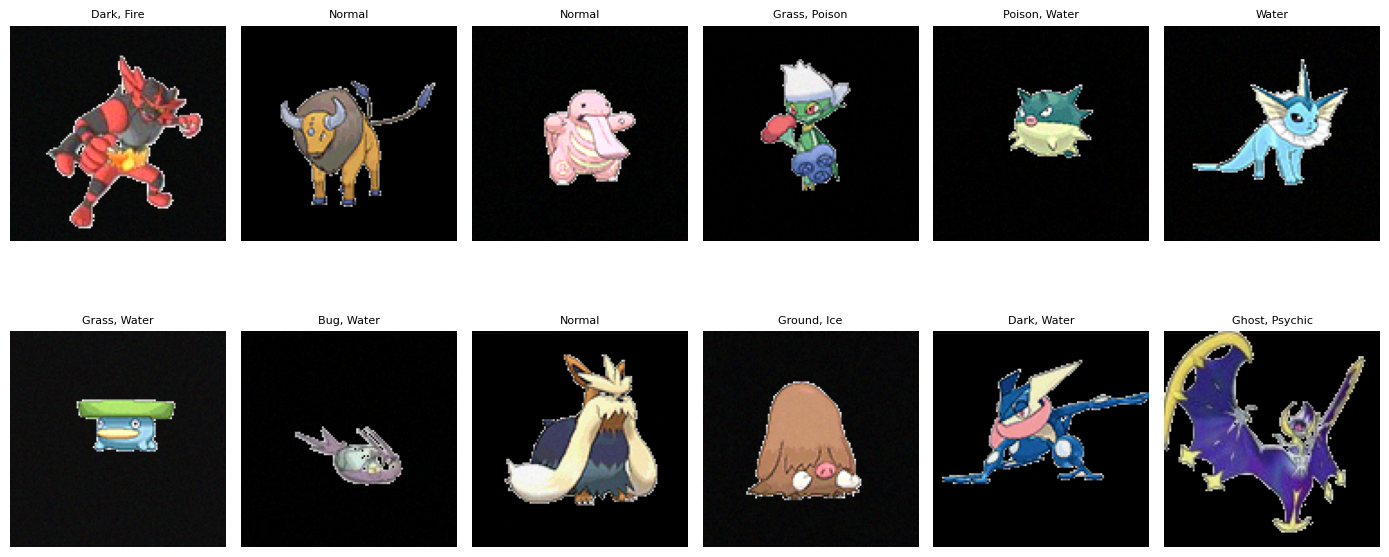

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

HAS_MLB = "mlb" in globals()

def decode_multihot(y_vec):
    y_vec = np.array(y_vec)
    idx = np.where(y_vec > 0.5)[0]
    if HAS_MLB:
        return ", ".join(mlb.classes_[idx]) if len(idx) else "None"
    return str(idx.tolist())

def show_batch_from_ds(ds, n=12, figsize=(14, 7)):
    for batch in ds.take(1):
        x, y = batch 
        x = x.numpy()
        y = y.numpy()

        n = min(n, x.shape[0])
        cols = 6
        rows = int(np.ceil(n / cols))

        plt.figure(figsize=figsize)
        for i in range(n):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title(decode_multihot(y[i]), fontsize=8)
        plt.tight_layout()
        plt.show()

show_batch_from_ds(train_aug, n=12)

In [ ]:
final_train_ds = tf.data.Dataset.sample_from_datasets(
    [train_base, train_aug],
    weights=[0.5, 0.5]
)

In [ ]:
def count_ds(ds):
    return (ds.unbatch()
              .map(lambda x, y: tf.constant(1, tf.int64))
              .reduce(tf.constant(0, tf.int64), lambda a, b: a + b)
              .numpy())

print("train_base size:", count_ds(train_base))
print("train_aug size :", count_ds(train_aug))

train_base size: 691
train_aug size : 691


In [ ]:
print("final_train_ds size :", count_ds(final_train_ds))

final_train_ds size : 1382


### Train Data set items

Shapes of items in dataset:

* Features:  (BATCH SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)    
* Label:     hot encoded

Shape of features array: (32, 120, 120, 3)
Shape of labels array: (32, 18)

Plot one of the images from the first batch


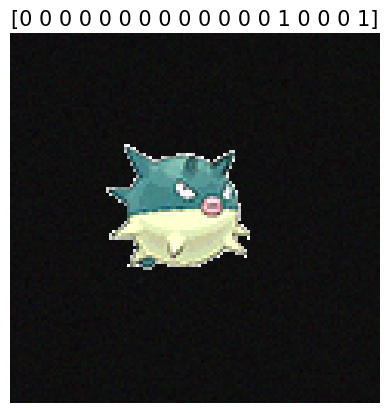

In [ ]:
for f, l in final_train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

    print("\nPlot one of the images from the first batch")
    plt.imshow(f[0])
    plt.title(str(l.numpy()[0]), size=15)
    plt.axis(False)

**Concatenating augmented dataset and regular dataset**

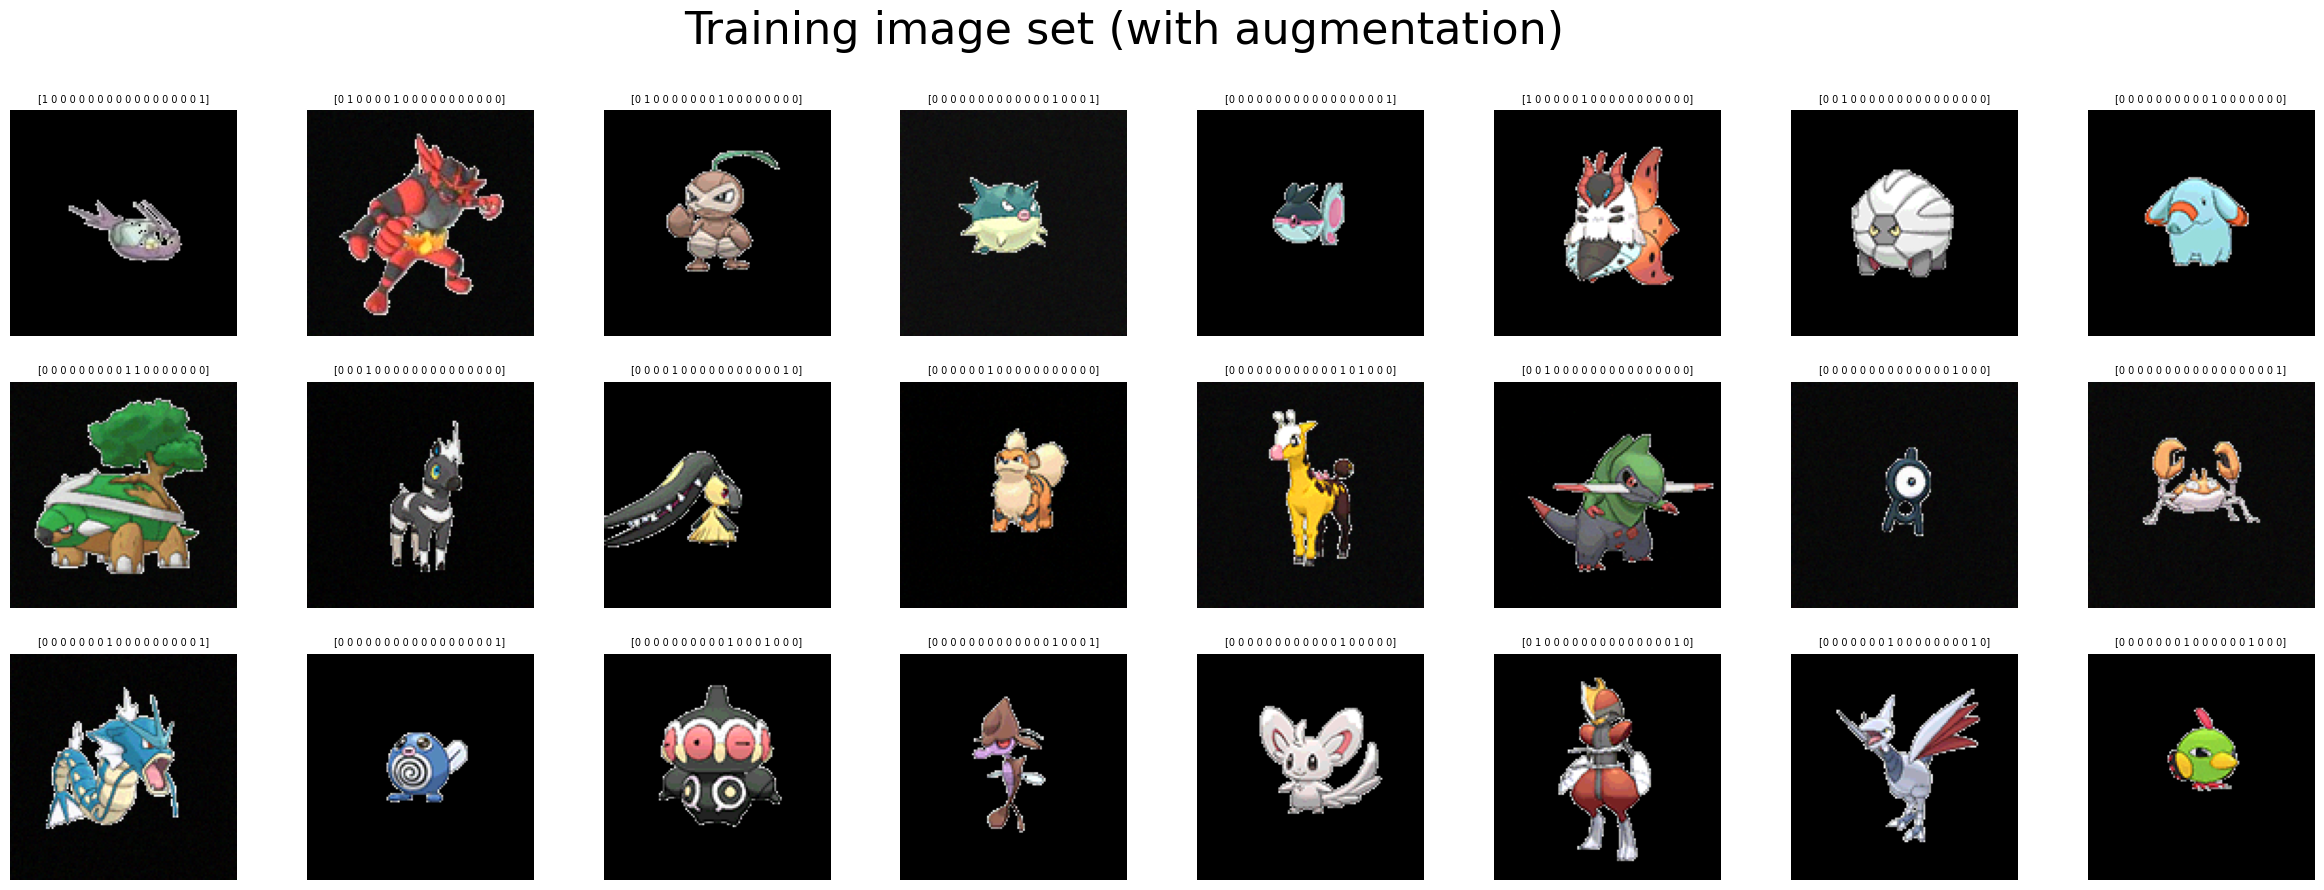

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(30, 10))
axes = axes.reshape(-1)

fig.suptitle('Training image set (with augmentation)', fontsize=32)

for idx, (f, l) in enumerate(final_train_ds.take(3*8)):
    axes[idx].imshow(f[0])
    axes[idx].set_title(str(l.numpy()[0]), size=7)
    axes[idx].axis(False)

## Model Building

### Classic CNN Architecture

In [ ]:
img = Image.open('/kaggle/input/pokemon-images-and-types/images/bulbasaur.png')
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
CHANNELS = 3
N_LABELS = 18

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

model = tf.keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(150, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(N_LABELS),
])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 118, 118, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 57, 57, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 3, 3, 150)      │       172,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 3, 3, 150)      │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 1, 1, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,784 (1.08 MB)

 Trainable params: 282,004 (1.08 MB)

 Non-trainable params: 780 (3.05 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

callbacks = [early_stopping]

In [ ]:
history = model.fit(final_train_ds,
                   epochs=50,
                   validation_data=val_ds,
                   callbacks=callbacks,
                   verbose=1)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.5176 - top_k_categorical_accuracy: 0.1392 - val_loss: 0.7267 - val_top_k_categorical_accuracy: 0.0649
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3028 - top_k_categorical_accuracy: 0.1986 - val_loss: 0.7930 - val_top_k_categorical_accuracy: 0.0649
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2682 - top_k_categorical_accuracy: 0.2952 - val_loss: 0.8111 - val_top_k_categorical_accuracy: 0.0779
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2435 - top_k_categorical_accuracy: 0.3967 - val_loss: 0.8060 - val_top_k_categorical_accuracy: 0.0519
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2212 - top_k_categorical_accuracy: 0.5002 - val_loss: 0.7654 - val_top_k_categorical_accuracy: 0.0519
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2006 - top_k_categorical_accuracy: 0.5946 - val_loss: 0.7035 - val_top_k_categorical_accuracy: 0.0519
Epoch 7/50
44/44 ━━━

## Learning curves

Mutli-label classification

This is a mutli-label classification problem because each pokemon can be of one or two types. So obviously, we cannot use categorical crossentropy loss here. We will explore applying pair-wise binary crossentropy and explore other clever loss functions.

We can develop our own heuristic loss function by applying some knowledge we have about the target domain. For example, misclassifying a point as Water when it is Ice is wrong, but it is more correct than misclassfying it as fire.


3/3 - 0s - 19ms/step - loss: 0.4051 - top_k_categorical_accuracy: 0.2727


Loss on validation set 0.405,  Categorical accuracy on validation set 0.273


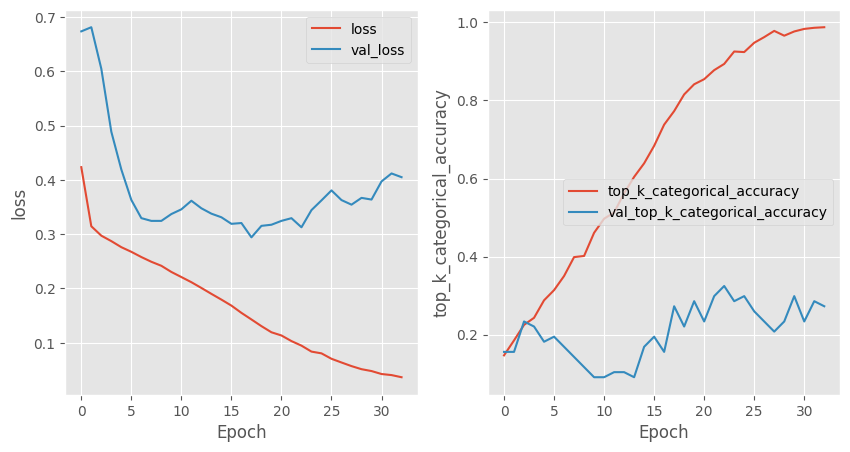

In [ ]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes):

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

val_loss, val_acc = model.evaluate(val_ds, verbose=2);
print("\n\nLoss on validation set {:.3},  Categorical accuracy on validation set {:.3f}".format(val_loss, val_acc))

## Visualize results

In [ ]:
def plot_prediction_grid(model, dataset, dims=(3, 3),print_types=True):
    """ Plots a prediction grid given an model and dataset

    model:   tf model
    dataset:  tf.data.Dataset
    print_types:  If True, will lookup string names for types
    """
    i, j = dims

    fig, axes = plt.subplots(i, j, figsize=(3*i, 3*j))
    axes.reshape(-1, 1)

    for f, l in dataset.take(1):


        # loop through one batch for N times
        for i, ax in enumerate(axes.reshape(-1)):

            ax.imshow(f[i])
            ax.axis(False)

            # make prediction on sample image from dataset
            sample_img = np.expand_dims(f[i], axis=0)
            pred_raw = model.predict(sample_img)
            pred_soft = tf.keras.layers.Softmax()(pred_raw)
            pred_idx = pred_soft[0].numpy().argsort()[-2:][::-1]

            # get actual label
            idx_labels = np.where(l[i].numpy() == 1)[0]

            # write actual and prediction
            if print_types:
                act_types_str = []
                pred_types_str = []

                for idx in idx_labels:
                    act_types_str.append(type_encoding[idx])

                for idx in pred_idx:
                    pred_types_str.append(type_encoding[idx])

                idx_labels = act_types_str
                pred_idx = pred_types_str


            ax.set_title("Act: {}, Pred: {}".format(idx_labels, pred_idx), size=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


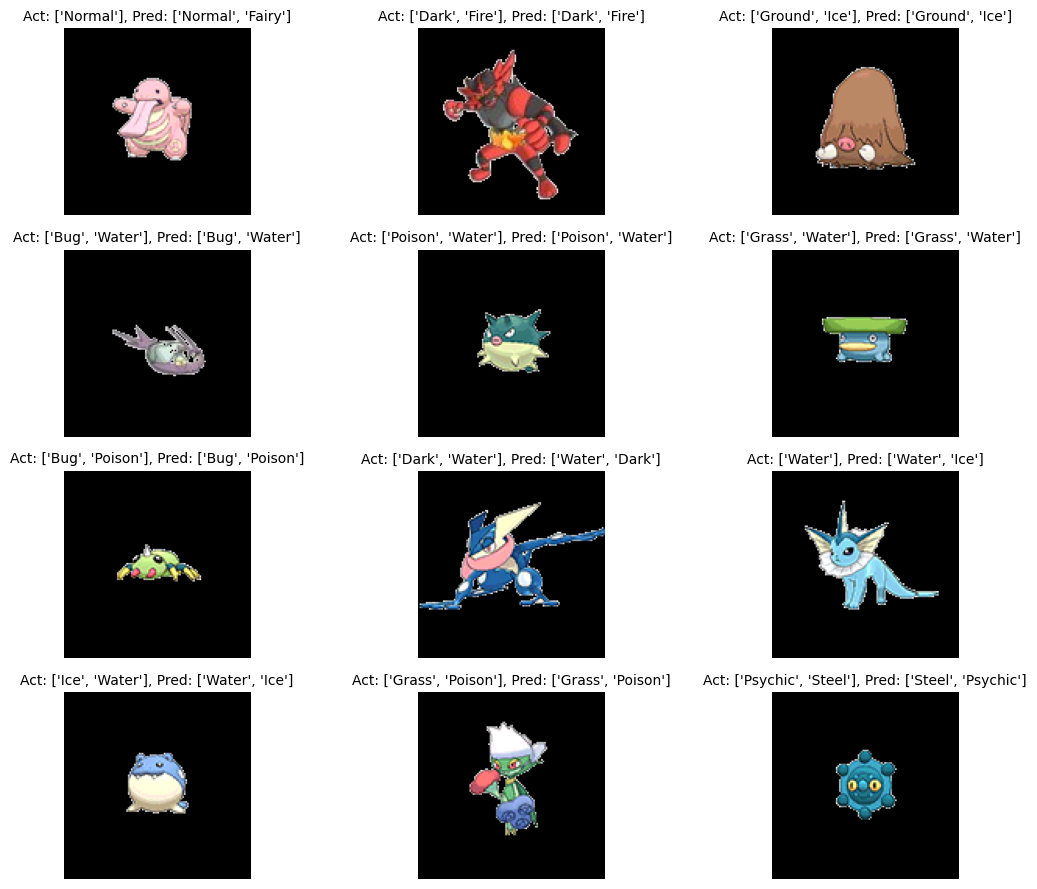

In [ ]:
# Training data
plot_prediction_grid(model,final_train_ds, (4, 3), True)
plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


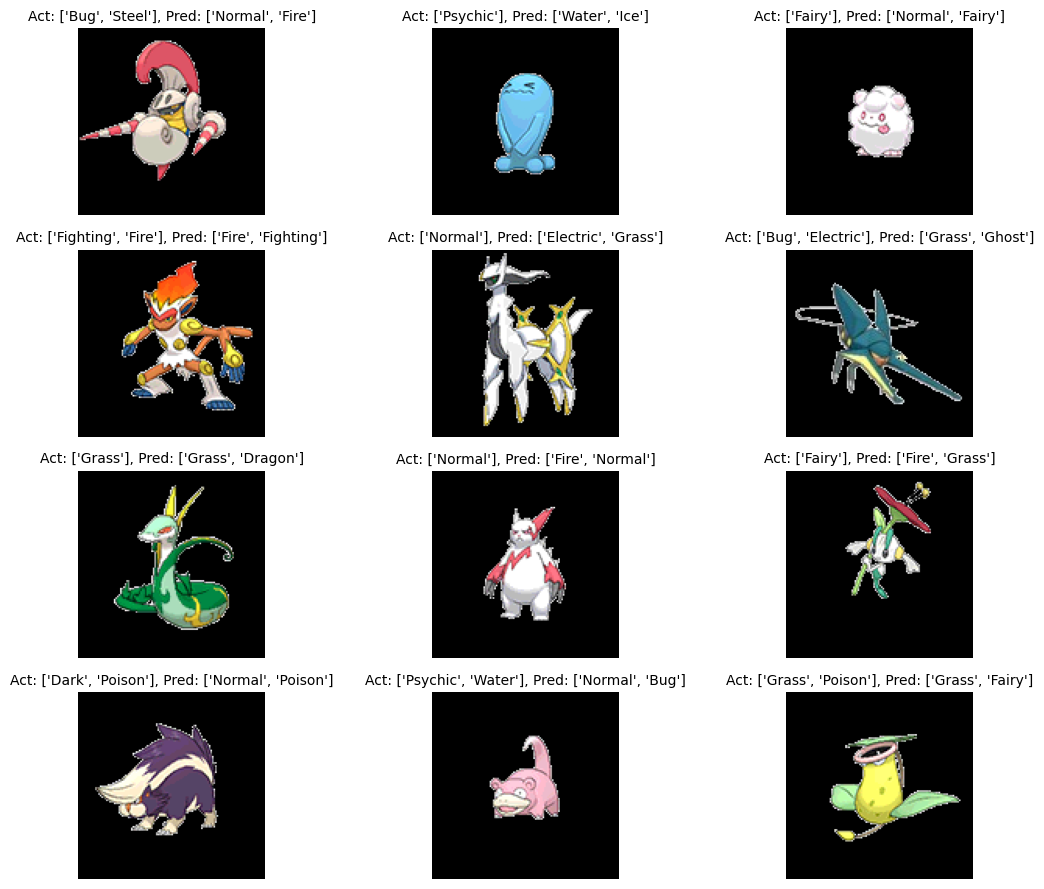

In [ ]:
## Test on test_set
plot_prediction_grid(model, test_ds, (4, 3), True)
plt.tight_layout()

## Test the model on new imgs

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests

# Pick 3 NEW (Gen8/Gen9) Pokemon images (official artwork in this case)
REAL_WORLD = {
    "Grookey (Gen8)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/810.png",
    "Sprigatito (Gen9)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/906.png",
    "Fuecoco (Gen9)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/909.png",
}

OUT_DIR = "/kaggle/working/real_world"
os.makedirs(OUT_DIR, exist_ok=True)

local_paths = []
names = []

headers = {"User-Agent": "Mozilla/5.0"}
for name, url in REAL_WORLD.items():
    fname = name.split("(")[0].strip().lower().replace(" ", "_") + ".png"
    path = os.path.join(OUT_DIR, fname)

    r = requests.get(url, headers=headers, timeout=30)
    r.raise_for_status()

    with open(path, "wb") as f:
        f.write(r.content)

    local_paths.append(path)
    names.append(name)

print("Downloaded:", local_paths)

# build tf.data.Dataset from these 3 images
IMG_SIZE = (120, 120) 

def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_png(img_bytes, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img

NUM_LABELS = len(type_encoding) 
dummy_y = tf.zeros((len(local_paths), NUM_LABELS), dtype=tf.float32)

real_world_ds = tf.data.Dataset.from_tensor_slices((local_paths, dummy_y))
real_world_ds = real_world_ds.map(lambda p, y: (load_and_preprocess(p), y),
                                  num_parallel_calls=tf.data.AUTOTUNE).batch(3)

def plot_real_world_predictions_with_scores(model, ds, names_list, show_all=True, threshold=0.10, max_to_show=18):
    """
    show_all=True  -> show all labels with percentages (up to max_to_show if you want)
    show_all=False -> show only labels with prob >= threshold (and if empty, fallback to top-2)
    """
    for batch_imgs, _ in ds.take(1):
        preds = model.predict(batch_imgs, verbose=0)

        fig, axes = plt.subplots(1, batch_imgs.shape[0], figsize=(12, 4))
        if batch_imgs.shape[0] == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(batch_imgs[i].numpy())
            ax.axis("off")
            title = names_list[i] if i < len(names_list) else f"img {i}"

            if isinstance(preds, dict) or (isinstance(preds, (list, tuple)) and len(preds) == 2):
                if isinstance(preds, dict):
                    p1 = tf.nn.softmax(preds["type1"][i]).numpy()
                    p2 = tf.nn.softmax(preds["type2"][i]).numpy()
                else:
                    p1 = tf.nn.softmax(preds[0][i]).numpy()
                    p2 = tf.nn.softmax(preds[1][i]).numpy()

                # sort all labels by prob
                idx1 = np.argsort(p1)[::-1]
                idx2 = np.argsort(p2)[::-1]

                lines1 = [f"{type1_encoder.categories_[0][k]}: {p1[k]*100:.1f}%" for k in idx1[:min(len(idx1), 10)]]
                lines2 = [f"{type2_encoder.categories_[0][k]}: {p2[k]*100:.1f}%" for k in idx2[:min(len(idx2), 10)]]

                ax.set_title(f"{title}\nType1 (top):\n" + "\n".join(lines1) + "\n\nType2 (top):\n" + "\n".join(lines2),
                             fontsize=7)

            else:
                probs = tf.nn.sigmoid(preds[i]).numpy() 
                order = np.argsort(probs)[::-1] 

                if show_all:
                    order_to_show = order[:min(len(order), max_to_show)]
                else:
                    order_to_show = order[probs[order] >= threshold]
                    if len(order_to_show) == 0:
                        order_to_show = order[:2]

                lines = [f"{type_encoding[k]}: {probs[k]*100:.1f}%" for k in order_to_show]

                ax.set_title(f"{title}\n" + "\n".join(lines), fontsize=7)

        plt.tight_layout()
        plt.show()


Downloaded: ['/kaggle/working/real_world/grookey.png', '/kaggle/working/real_world/sprigatito.png', '/kaggle/working/real_world/fuecoco.png']


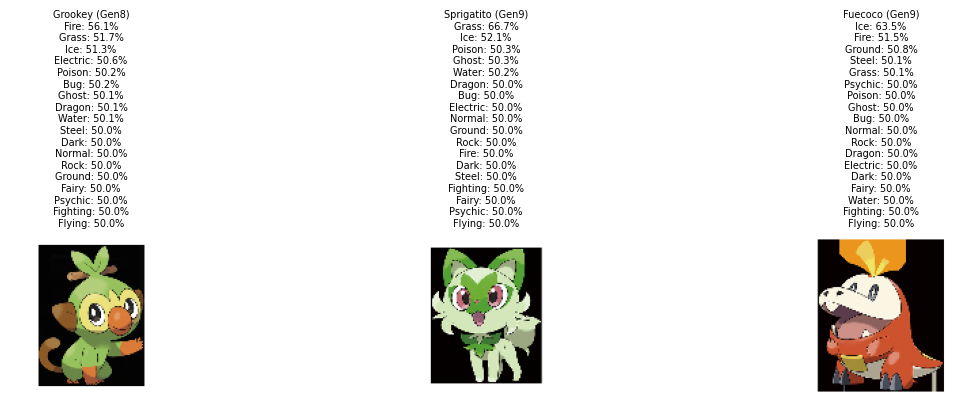

In [ ]:
# run evaluation on the 3 new images from internet
plot_real_world_predictions_with_scores(model, real_world_ds, names, show_all=True, max_to_show=len(type_encoding))


### Transfer Learning from MobileNetV2


In [ ]:
IMG_SHAPE = (120, 120, 3)

# create the base model from the pre trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(120, 120, 3),
    include_top=False,
    weights="imagenet"
)

/tmp/ipython-input-2196397288.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(N_LABELS)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

mobile_net_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(N_LABELS)
])

In [ ]:
mobile_net_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,756,856 (10.52 MB)

 Trainable params: 166,290 (649.57 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 332,582 (1.27 MB)

In [ ]:
mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

callbacks = [early_stopping]

In [ ]:
history = mobile_net_model.fit(final_train_ds,
                   epochs=50,
                   validation_data=val_ds,
                   callbacks=callbacks,
                   verbose=1)

Epoch 1/50
     42/Unknown 14s 125ms/step - loss: 0.7191 - top_k_categorical_accuracy: 0.0937

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - loss: 0.7065 - top_k_categorical_accuracy: 0.0945 - val_loss: 0.3213 - val_top_k_categorical_accuracy: 0.0909
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3560 - top_k_categorical_accuracy: 0.1096 - val_loss: 0.2992 - val_top_k_categorical_accuracy: 0.1688
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3283 - top_k_categorical_accuracy: 0.1614 - val_loss: 0.2919 - val_top_k_categorical_accuracy: 0.1818
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3079 - top_k_categorical_accuracy: 0.1895 - val_loss: 0.2860 - val_top_k_categorical_accuracy: 0.2078
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2974 - top_k_categorical_accuracy: 0.2164 - val_loss: 0.2841 - val_top_k_categorical_accuracy: 0.2078
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2905 - top_k_categorical_accuracy: 0.2495 - val_loss: 0.2804 - val_top_k_categorical_accuracy: 0.2468
Epoch 7/50
44/44 ━━━━━━━━━━━━━━

#### Learning curves

3/3 - 0s - 15ms/step - loss: 0.2752 - top_k_categorical_accuracy: 0.3506


Loss on test set 0.275,  Categorical accuracy on val set 0.351


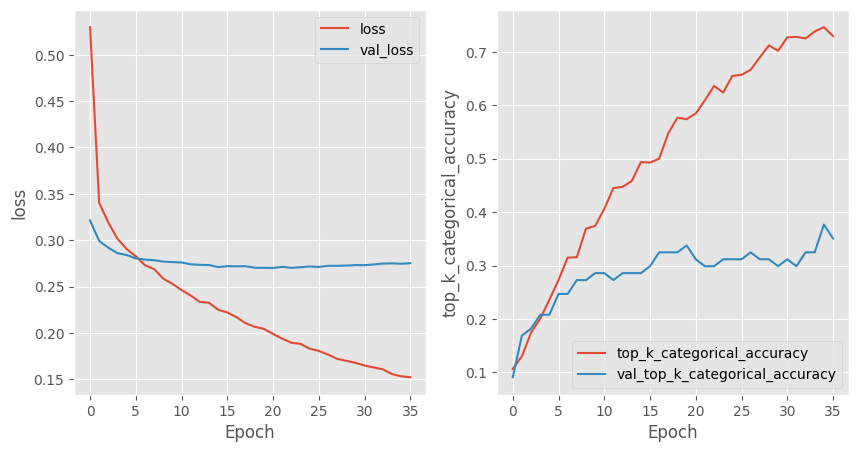

In [ ]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes):

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

val_loss, val_acc = mobile_net_model.evaluate(val_ds, verbose=2);
print("\n\nLoss on test set {:.3},  Categorical accuracy on val set {:.3f}".format(val_loss, val_acc))

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests

#  pick 3 NEW (Gen8/Gen9) Pokemon images (official artwork in this case) 
REAL_WORLD = {
    "Grookey (Gen8)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/810.png",
    "Sprigatito (Gen9)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/906.png",
    "Fuecoco (Gen9)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/909.png",
}

OUT_DIR = "/kaggle/working/real_world"
os.makedirs(OUT_DIR, exist_ok=True)

local_paths = []
names = []

headers = {"User-Agent": "Mozilla/5.0"}  # helps in some environments
for name, url in REAL_WORLD.items():
    fname = name.split("(")[0].strip().lower().replace(" ", "_") + ".png"
    path = os.path.join(OUT_DIR, fname)

    r = requests.get(url, headers=headers, timeout=30)
    r.raise_for_status()

    with open(path, "wb") as f:
        f.write(r.content)

    local_paths.append(path)
    names.append(name)

print("Downloaded:", local_paths)

#  build tf.data.Dataset from these 3 images 
IMG_SIZE = (120, 120)  

def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_png(img_bytes, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img

NUM_LABELS = len(type_encoding) 
dummy_y = tf.zeros((len(local_paths), NUM_LABELS), dtype=tf.float32)

real_world_ds = tf.data.Dataset.from_tensor_slices((local_paths, dummy_y))
real_world_ds = real_world_ds.map(lambda p, y: (load_and_preprocess(p), y),
                                  num_parallel_calls=tf.data.AUTOTUNE).batch(3)

def plot_real_world_predictions_with_scores(model, ds, names_list, show_all=True, threshold=0.10, max_to_show=18):
    """
    show_all=True  -> show all labels with percentages (up to max_to_show if you want)
    show_all=False -> show only labels with prob >= threshold (and if empty, fallback to top-2)
    """
    for batch_imgs, _ in ds.take(1):
        preds = mobile_net_model.predict(batch_imgs, verbose=0)

        fig, axes = plt.subplots(1, batch_imgs.shape[0], figsize=(12, 4))
        if batch_imgs.shape[0] == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(batch_imgs[i].numpy())
            ax.axis("off")
            title = names_list[i] if i < len(names_list) else f"img {i}"

            if isinstance(preds, dict) or (isinstance(preds, (list, tuple)) and len(preds) == 2):
                if isinstance(preds, dict):
                    p1 = tf.nn.softmax(preds["type1"][i]).numpy()
                    p2 = tf.nn.softmax(preds["type2"][i]).numpy()
                else:
                    p1 = tf.nn.softmax(preds[0][i]).numpy()
                    p2 = tf.nn.softmax(preds[1][i]).numpy()

                idx1 = np.argsort(p1)[::-1]
                idx2 = np.argsort(p2)[::-1]

                lines1 = [f"{type1_encoder.categories_[0][k]}: {p1[k]*100:.1f}%" for k in idx1[:min(len(idx1), 10)]]
                lines2 = [f"{type2_encoder.categories_[0][k]}: {p2[k]*100:.1f}%" for k in idx2[:min(len(idx2), 10)]]

                ax.set_title(f"{title}\nType1 (top):\n" + "\n".join(lines1) + "\n\nType2 (top):\n" + "\n".join(lines2),
                             fontsize=7)

            else:
                probs = tf.nn.sigmoid(preds[i]).numpy() 
                order = np.argsort(probs)[::-1]

                if show_all:
                    order_to_show = order[:min(len(order), max_to_show)]
                else:
                    order_to_show = order[probs[order] >= threshold]
                    if len(order_to_show) == 0:
                        order_to_show = order[:2]

                lines = [f"{type_encoding[k]}: {probs[k]*100:.1f}%" for k in order_to_show]

                ax.set_title(f"{title}\n" + "\n".join(lines), fontsize=7)

        plt.tight_layout()
        plt.show()

Downloaded: ['/kaggle/working/real_world/grookey.png', '/kaggle/working/real_world/sprigatito.png', '/kaggle/working/real_world/fuecoco.png']


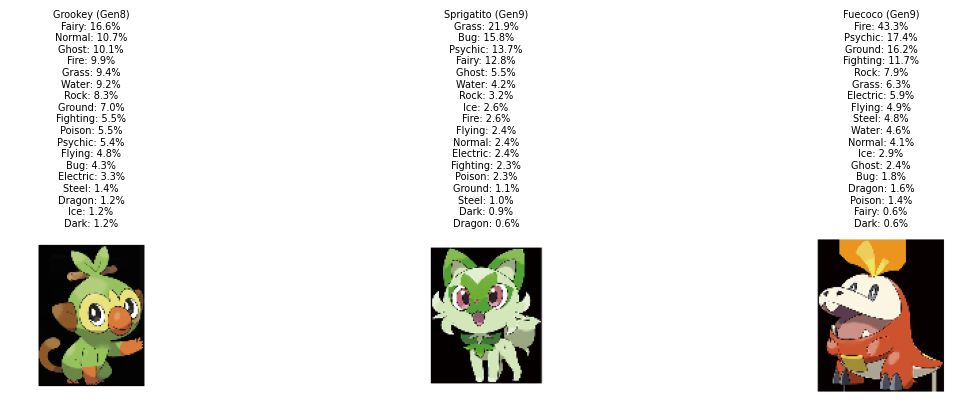

In [ ]:
#  run mobile_netV2 on the 3 new images from internet
plot_real_world_predictions_with_scores(mobile_net_model, real_world_ds, names, show_all=True, max_to_show=len(type_encoding))

### Transfer Learning - EfficientNetV2B0

In [ ]:
IMG_SHAPE = (120, 120, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(120, 120, 3),
    include_top=False,
    weights="imagenet"
)

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(N_LABELS)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

Efficient_net_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(N_LABELS, activation="sigmoid")
])

In [ ]:
Efficient_net_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,085,602 (23.21 MB)

 Trainable params: 166,290 (649.57 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
Efficient_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

callbacks = [early_stopping]

In [ ]:
history = Efficient_net_model.fit(final_train_ds,
                   epochs=50,
                   validation_data=val_ds,
                   callbacks=callbacks,
                   verbose=1)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


     42/Unknown 38s 312ms/step - loss: 0.6139 - top_k_categorical_accuracy: 0.0904

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 528ms/step - loss: 0.6075 - top_k_categorical_accuracy: 0.0910 - val_loss: 0.3445 - val_top_k_categorical_accuracy: 0.0909
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.3546 - top_k_categorical_accuracy: 0.1178 - val_loss: 0.2811 - val_top_k_categorical_accuracy: 0.1688
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3165 - top_k_categorical_accuracy: 0.1250 - val_loss: 0.2730 - val_top_k_categorical_accuracy: 0.1688
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3113 - top_k_categorical_accuracy: 0.1151 - val_loss: 0.2717 - val_top_k_categorical_accuracy: 0.1688
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3093 - top_k_categorical_accuracy: 0.1252 - val_loss: 0.2710 - val_top_k_categorical_accuracy: 0.1688
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3104 - top_k_categorical_accuracy: 0.1139 - val_loss: 0.2712 - val_top_k_categorical_accuracy: 0.1688
Epoch 7/50
44/44 ━━━━━━━━━━━━━━

3/3 - 0s - 49ms/step - loss: 0.2697 - top_k_categorical_accuracy: 0.1558


Loss on test set 0.27,  Categorical accuracy on val set 0.156


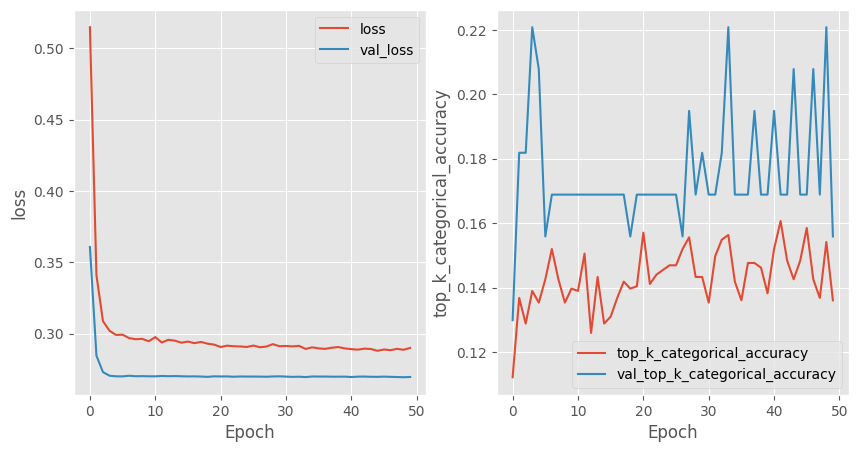

In [ ]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes):

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

val_loss, val_acc = Efficient_net_model.evaluate(val_ds, verbose=2);
print("\n\nLoss on test set {:.3},  Categorical accuracy on val set {:.3f}".format(val_loss, val_acc))

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests

REAL_WORLD = {
    "Grookey (Gen8)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/810.png",
    "Sprigatito (Gen9)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/906.png",
    "Fuecoco (Gen9)": "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/909.png",
}

OUT_DIR = "/kaggle/working/real_world"
os.makedirs(OUT_DIR, exist_ok=True)

local_paths = []
names = []

headers = {"User-Agent": "Mozilla/5.0"} 
for name, url in REAL_WORLD.items():
    fname = name.split("(")[0].strip().lower().replace(" ", "_") + ".png"
    path = os.path.join(OUT_DIR, fname)

    r = requests.get(url, headers=headers, timeout=30)
    r.raise_for_status()

    with open(path, "wb") as f:
        f.write(r.content)

    local_paths.append(path)
    names.append(name)

print("Downloaded:", local_paths)

IMG_SIZE = (120, 120) 
def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_png(img_bytes, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img


NUM_LABELS = len(type_encoding) 
dummy_y = tf.zeros((len(local_paths), NUM_LABELS), dtype=tf.float32)

real_world_ds = tf.data.Dataset.from_tensor_slices((local_paths, dummy_y))
real_world_ds = real_world_ds.map(lambda p, y: (load_and_preprocess(p), y),
                                  num_parallel_calls=tf.data.AUTOTUNE).batch(3)

def plot_real_world_predictions_with_scores(model, ds, names_list, show_all=True, threshold=0.10, max_to_show=18):
    """
    show_all=True  -> show all labels with percentages (up to max_to_show if you want)
    show_all=False -> show only labels with prob >= threshold (and if empty, fallback to top-2)
    """
    for batch_imgs, _ in ds.take(1):
        preds = Efficient_net_model.predict(batch_imgs, verbose=0)

        fig, axes = plt.subplots(1, batch_imgs.shape[0], figsize=(12, 4))
        if batch_imgs.shape[0] == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(batch_imgs[i].numpy())
            ax.axis("off")
            title = names_list[i] if i < len(names_list) else f"img {i}"

            if isinstance(preds, dict) or (isinstance(preds, (list, tuple)) and len(preds) == 2):
                if isinstance(preds, dict):
                    p1 = tf.nn.softmax(preds["type1"][i]).numpy()
                    p2 = tf.nn.softmax(preds["type2"][i]).numpy()
                else:
                    p1 = tf.nn.softmax(preds[0][i]).numpy()
                    p2 = tf.nn.softmax(preds[1][i]).numpy()

                idx1 = np.argsort(p1)[::-1]
                idx2 = np.argsort(p2)[::-1]

                lines1 = [f"{type1_encoder.categories_[0][k]}: {p1[k]*100:.1f}%" for k in idx1[:min(len(idx1), 10)]]
                lines2 = [f"{type2_encoder.categories_[0][k]}: {p2[k]*100:.1f}%" for k in idx2[:min(len(idx2), 10)]]

                ax.set_title(f"{title}\nType1 (top):\n" + "\n".join(lines1) + "\n\nType2 (top):\n" + "\n".join(lines2),
                             fontsize=7)

            else:
                probs = tf.nn.sigmoid(preds[i]).numpy()
                order = np.argsort(probs)[::-1]

                if show_all:
                    order_to_show = order[:min(len(order), max_to_show)]
                else:
                    order_to_show = order[probs[order] >= threshold]
                    if len(order_to_show) == 0:
                        order_to_show = order[:2]

                lines = [f"{type_encoding[k]}: {probs[k]*100:.1f}%" for k in order_to_show]

                ax.set_title(f"{title}\n" + "\n".join(lines), fontsize=7)

        plt.tight_layout()
        plt.show()

Downloaded: ['/kaggle/working/real_world/grookey.png', '/kaggle/working/real_world/sprigatito.png', '/kaggle/working/real_world/fuecoco.png']


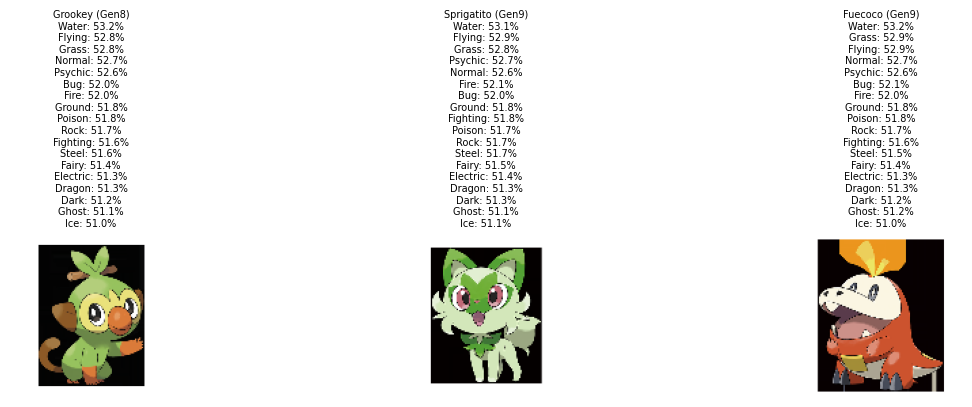

In [ ]:
# run Efficent_net evaluation on the 3 new images
plot_real_world_predictions_with_scores(Efficient_net_model, real_world_ds, names, show_all=True, max_to_show=len(type_encoding))